In [33]:
using Parameters
using Plots
using Optim
using Optim: minimum, minimizer

using QuantEcon
using Interpolations
using ConcreteStructs
using Plots, StatsPlots
using Interpolations
using QuantEcon
using Parameters
using Optim
using Optim: minimum, minimizer
using TransformVariables
using FastChebInterp
using DataFrames, DataFramesMeta
using ConcreteStructs
using Roots
using ProgressMeter
using Statistics
using TexTables


# Section B

## Question 1

Part a

$$v(k_0)=\max_{\{c_t, x_{t+1}\}_{t=0}^{\infty}} \sum_{t=0}^{\infty} \beta^t u(c_t)$$
$$ \text{s.t } x_{t+1} = 1 +x_t-c_t \text{ for all } t \geq 0 $$
Which can be rewritten as:
$$ v(k) = \max_{c, x'}  u(c) + \beta v(x')$$ 
$$ \text{s.t } x' = 1 +x-c$$

To see why this works, let BC(x) encode the budget constraint set with starting cake x.
$$v(k_0)=\max_{(c_t, x_{t+1})\in BC(x_t)} \sum_{t=0}^{\infty} \beta^t u(c_t)$$
Next we split off $t=0$:
$$=\max_{(c_t, x_{t+1})\in BC(x_t)} u(c_0) + \sum_{t=1}^{\infty} \beta^t u(c_t)$$
Next we factor out $\beta$ and split up the max:
$$=\max_{(c_0, x_1)\in BC(x_0)} u(c_0) + \beta \left( \max_{(c_t, x_{t+1})\in BC(x_t)} \sum_{t=1}^{\infty} \beta^{t-1} u(c_t) \right) $$
Next we reindex the sum:
$$=\max_{(c_0, x_1)\in BC(x_0)} u(c_0) + \beta \left( \max_{(c_t, x_{t+1})\in BC(x_t)}  \sum_{t=0}^{\infty} \beta^{t} u(c_{t+1}) \right) $$
Next we substitute the definition of v back into the equation:
$$=\max_{(c_0, x_1)\in BC(x_0)} u(c_0) + \beta v(x_1) $$
Where we then use the fact that $x_1$ is equivalent to $x'$ which shows x next period.

Part b

In [34]:
# Some options for interpolation 
abstract type ContinuousInterp          end
struct CubicSplines <: ContinuousInterp end 
struct LinearInterp <: ContinuousInterp end 
struct ChebyInterp  <: ContinuousInterp end 
struct GridSearch
    Nl::Int
end 

interpolant(::CubicSplines, grid, V) = cubic_spline_interpolation(grid, V)
interpolant(::LinearInterp, grid, V) = linear_interpolation(grid, V)
interpolant(::ChebyInterp, grid, V)  = chebinterp(V, extrema(grid)...)
interpolant(::GridSearch, grid, V)   = throw(error(
    "You should not be constructing an interpolant if you are doing a grid search"
))

interpolant (generic function with 4 methods)

In [35]:
function u(p, c)
    @unpack σ = p
    c < 1e-8 && return u(p, 1e-8) - 100 * (c - 1e-8)^2
    return c^(1-σ)/(1-σ)
end

"""
RamseyParams contains all of the parameters that we need to solve the
neoclassical growth model (Ramsey Model) with endogenous labour supply. 
This allows us to pass it around as a single object. 
"""
@kwdef @concrete struct RamseyParams
    β = 0.95
    σ = 2.5
    Nk = 50
    interp_mode = CubicSplines()
end
Base.broadcastable(p::RamseyParams) = Ref(p) # makes broadcasting work properly

In [84]:
function solve!(p::RamseyParams, m; 
    tol = 1e-6, maxiter = 1000, debug = false,
    policy_steps = 0)
    
    @unpack V, V0  = m
    @unpack interp_mode = p
    V_old  = copy(V0)
    err  = Inf 
    iter = 0
    errors = []
    while true 
        
        iter += 1
        
        # Solve the maximization problem
        iterate_bellman!(p, m, interp_mode)
        V0 .= V

        # Policy Update Steps 
        if err < 10
            for s in 1:policy_steps
                iterate_policy!(p, m, interp_mode)
                V0 .= V
            end
        end
        
        err = maximum(abs.(V .- V_old))
        push!(errors, err)
        debug && @info "Debugging" iter err
        err < tol       && break 
        iter >= maxiter && break 
        V_old .= V
    end

    return (; m, iter, errors)
end

solve! (generic function with 1 method)

In [37]:
"""
    iterate_bellman!(p::RamseyParams, m, method::GridSearch)

This updates our Bellman equation using a grid search over all possible values
of x.  
"""
function iterate_bellman!(p::RamseyParams, m, method::GridSearch)
    @unpack xgrid, V0, V, policy = m 
    @unpack β  = p

    Threads.@threads for i in eachindex(xgrid)
        
        # Do a grid search: notice that lgrid is transposed
        # This means we're constructing an Nk x Nl matrix, with capital chosen
        # tomorrow on the rows, and labour supply chosen today along the columns
        # Notice as well: I've substituted in the budget constraint already
        x         = xgrid[i]
        c(x′)   = 1 + x - x′
            # This is the consumption that they will get for every possible
            # choice (Nk x Nl) matrix
        obj = u.(p, c.(xgrid)) .+ β .* V0
            # We're calculating all the possible values of the objective
            # function, for all of the possible choices, and storing them in a
            # matrix called obj
        
        # Find the point that maximizes the objective
        v, sub = findmax(obj)
        zx     = sub 
            # note that the index of the maximum is two numbers: (zk, zl)
        x′ = xgrid[zx] 

        V[i]          = v
        policy.x[i]   = x′
        policy.c[i]   = 1 + x - x′
        yield()
    end
end

iterate_bellman!

In [38]:
p = RamseyParams(
    β = 0.95, 
    σ = 2, 
    Nk = 50,
    interp_mode = GridSearch(50)
)

setup(p) = setup(p, p.interp_mode)

function setup(p::RamseyParams, method::GridSearch)
    @unpack Nk = p
    @unpack Nl = method

    xgrid = LinRange(1e-4, 10, Nk)
    
    return (
        V = zeros(Nk),
        policy = (
            x  = zeros(Nk),
            c  = zeros(Nk)
        ),
        V0 = zeros(Nk),
        xgrid 
    )
end

m = setup(p)
@time solve!(p, m, tol = 1e-6)

  0.248530 seconds (263.93 k allocations: 23.197 MiB, 93.69% compilation time)


(m = (V = [-19.999981629243987, -19.830491511464125, -19.669475899573253, -19.51651106827693, -19.371194478545416, -19.233143718300486, -19.1019954960678, -18.977404684946748, -18.857041788659902, -18.7386805180949  …  -16.104625595639387, -16.039586290450494, -15.975628583912137, -15.912732232809914, -15.849957669518592, -15.788170329589146, -15.727410508377703, -15.667658974830593, -15.608023139703844, -15.549325166770869], policy = (x = [0.0001, 0.0001, 0.20417959183673468, 0.40825918367346936, 0.6123387755102041, 0.8164183673469387, 1.0204979591836736, 1.2245775510204082, 1.2245775510204082, 1.4286571428571426  …  7.346965306122449, 7.551044897959183, 7.755124489795918, 7.959204081632653, 8.163283673469389, 8.367363265306123, 8.571442857142857, 8.775522448979592, 8.979602040816326, 9.183681632653062], c = [1.0, 1.2040795918367346, 1.2040795918367349, 1.2040795918367349, 1.2040795918367346, 1.2040795918367349, 1.2040795918367344, 1.2040795918367342, 1.408159183673469, 1.408159183673

In [51]:
function iterate_bellman!(p::RamseyParams, m, method::ContinuousInterp)
    @unpack σ = p
    @unpack V, policy, V0, xgrid = m

    # Use cubic splines to interpolate continuation value 
    V̂ = interpolant(method, xgrid, V0)

    Threads.@threads for i in eachindex(xgrid)
        # k is from the grid.  Initial guess is our solution at this grid point
        # from the previous iteration
        x       = xgrid[i]
        # guess   = [policy.cs[i], policy.l[i]]
        guess   = [0.5]
        
        @unpack v′, pol = solve_inner(p, m, x, V̂, guess)
        V[i]         = v′
        
    end
    return 
end

function solve_inner(p::RamseyParams, m, k, V̂, x0)

    # Solve the optimization problem 
    t    = as(Array, as(Real, 1.0e-4, 1.0 - 1.0e-4), 1) 
    # h(x) = 1/(1 + exp(x))
    h(x) = TransformVariables.transform(t, x)
    opt = LBFGS()
    obj = min_objective(optimization_objective(p, m, k, V̂))
    res = optimize(x -> obj(h(x)), x0, opt, 
        Optim.Options(
            x_tol = 1e-10, 
            f_tol = 1e-10,
        ),
        autodiff = :forward     
    )

    return (; v′ = -minimum(res), pol = h(minimizer(res)), res)
end

function optimization_objective(p::RamseyParams, m, k, V̂)
    @unpack β, σ  = p
    k̲, k̅ = extrema(m.xgrid)
    kbd  = bounded(extrema(m.xgrid)...)
    # Define optimization objective
    return function obj(x) 
        z = 1 - k
        c = z  
        x′ = max(min(z, k̅), k̲)
        v′ =  u(p, c) + β * V̂(x′)
        return v′
    end
end

min_objective(obj) = (x...) -> -obj(x...)
bounded(lb, ub)    = x -> max(min(x, ub), lb)

bounded (generic function with 1 method)

In [52]:
p = RamseyParams(
    β = 0.95, 
    σ = 2, 
    Nk = 50,
    interp_mode = LinearInterp()
)

setup(p) = setup(p, p.interp_mode)

function setup(p::RamseyParams, method::ContinuousInterp)
    @unpack Nk = p

    xgrid = LinRange(1e-4, 10, Nk)
    
    return (
        V = zeros(Nk),
        policy = (
            x  = zeros(Nk),
            c  = zeros(Nk)
        ),
        V0 = zeros(Nk),
        xgrid 
    )
end

m = setup(p)
@time solve!(p, m, tol = 1e-6)

  0.712076 seconds (3.26 M allocations: 232.919 MiB, 8.77% gc time, 86.06% compilation time: 26% of which was recompilation)


(m = (V = [-5.720653943644071e8, -2.1020361060247794e8, -9.859512566787149e7, -1.0436689114446808e8, -2.343903568320711e8, -6.434621246882024e8, -6.434621296896938e8, -6.434621430208812e8, -6.434621646817646e8, -6.434621946723439e8  …  -6.434672559094987e8, -6.434675524503489e8, -6.434678573208948e8, -6.434681705211368e8, -6.434684920510747e8, -6.434688219107085e8, -6.434691601000384e8, -6.434695066190642e8, -6.434698614677861e8, -6.434702246462038e8], policy = (x = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], c = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), V0 = [-5.720653943644071e8, -2.1020361060247794e8, -9.859512566787149e7, -1.0436689114446808e8, -2.343903568320711e8, -6.434621246882024e8, -6.434621296896938e8, -6.434621430208812e8, -6.434621646817646e8, -6.434621946723439e8  …  -6.434672559094987e8, -6.434675524503489e8, -6.434678573208948e8, -6.43468170521136

  0.056868 seconds (974.12 k allocations: 71.517 MiB, 22.63% gc time)
  0.096204 seconds (2.00 M allocations: 146.488 MiB, 17.99% gc time)
  0.151828 seconds (3.36 M allocations: 246.614 MiB, 14.20% gc time)


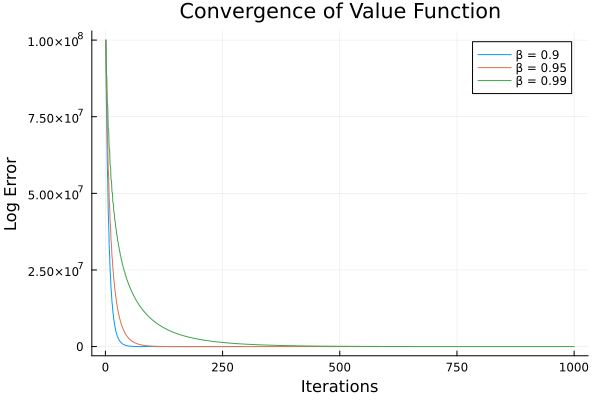

attempt to save state beyond implementation limit
attempt to save state beyond implementation limit


In [89]:
using Plots

beta_vals = [0.9, 0.95, 0.99]
plot()

for i in 1:3
    p = RamseyParams(
        β = beta_vals[i], 
        σ = 2, 
        Nk = 50,
        interp_mode = LinearInterp()
    )

    # Assuming setup function is defined outside the loop
    m = setup(p)

    @time @unpack iter, errors = solve!(p, m, tol = 1e-6)
    
    # Plot errors for each iteration
    plot!(1:iter, errors, label = "β = $(beta_vals[i])")
end

plot!(legend=:topright, xlabel = "Iterations", ylabel = "Log Error", title = "Convergence of Value Function")


In [79]:
using Plots

beta_vals = [0.9, 0.95, 0.99]
p = plot()  # Initialize an empty plot

for i in 1:3
    params = RamseyParams(
        β = beta_vals[i], 
        σ = 2, 
        Nk = 50,
        interp_mode = LinearInterp()
    )

    setup(params) = setup(params, params.interp_mode)

    m = setup(params)
    @time solve!(params, m, tol = 1e-6)
    @unpack iter, err = solve!(params, m, tol = 1e-6)    
    plot!(1:iter+1, [err], label = "β = $(beta_vals[i])", legend=:topleft)
    display(p)
end






  0.075457 seconds (973.84 k allocations: 71.505 MiB, 10.43% gc time)


attempt to save state beyond implementation limit
attempt to save state beyond implementation limit
attempt to save state beyond implementation limit


  0.101899 seconds (1.99 M allocations: 146.474 MiB, 23.92% gc time)


attempt to save state beyond implementation limit
attempt to save state beyond implementation limit
attempt to save state beyond implementation limit


  0.151960 seconds (3.36 M allocations: 246.579 MiB, 15.03% gc time)


attempt to save state beyond implementation limit
attempt to save state beyond implementation limit
attempt to save state beyond implementation limit


## Question 2

Part a

In [2]:
# Some options for interpolation 
abstract type ContinuousInterp          end
struct CubicSplines <: ContinuousInterp end 
struct LinearInterp <: ContinuousInterp end 
struct ChebyInterp  <: ContinuousInterp end 
struct GridSearch
    Nl::Int
end 

interpolant(::CubicSplines, grid, V) = cubic_spline_interpolation(grid, V)
interpolant(::LinearInterp, grid, V) = linear_interpolation(grid, V)
interpolant(::ChebyInterp, grid, V)  = chebinterp(V, extrema(grid)...)
interpolant(::GridSearch, grid, V)   = throw(error(
    "You should not be constructing an interpolant if you are doing a grid search"
))

interpolant (generic function with 4 methods)

In [3]:
@with_kw struct BewleyParameters{T}
    β::Float64  = 0.95  
        # these type annotations (::Float64) are needed when defining a new
        # struct Julia's compiler needs to know how to lay this new object out
        # in memory
    r::Float64  = .03   
    μ::Float64  = 0.5   
    ρ::Float64  = 0.7
    σϵ::Float64 = 0.16
    σ::Float64  = 2.5
    δ::Float64  = 0.0
    φ::Float64 = 0.05
    τy::Float64 = 0.0   # income tax  -- not used until part (d)
    τa::Float64 = 0.0   # capital tax -- not used until part (d)
    Na::Int     = 100
    Ny::Int     = 15
    interp_mode::T = CubicSplines()
        # Here, we've annotated the type as ::T (which also shows up in the type
        # definition: BewleyParams{T}). This means that T is a type parameter --
        # it can take any value that we want
    
end
Base.broadcastable(p::BewleyParameters) = Ref(p) # makes broadcasting work properly

u(p, c) = (@unpack σ = p;  c^(1-σ)/(1-σ))


function setup(p::BewleyParameters, interp_mode::ContinuousInterp)
    @unpack Na, Ny, ρ, σϵ, μ = p 
    
    # Capital Grid 
    if interp_mode isa ChebyInterp
        agrid = chebpoints(Na-1, 0, 300)
    else
        agrid = LinRange(0, 500, Na)
    end
    
    # Discretize income grid
    mc    = rouwenhorst(Ny, ρ, σϵ, μ)
    ygrid = mc.state_values 
    P     = mc.p'

    # Setup guesses 
    V  = zeros(Na, Ny)
    V0 = zeros(Na, Ny)
    EV = zeros(Na, Ny)

    policy = (
        c = zeros(Na, Ny),
        a = zeros(Na, Ny)
    )

    return (; V, V0, EV, policy, agrid, ygrid, P)
end

function solve!(p::BewleyParameters, m; tol = 1e-8, maxiter = 1000)
    @unpack V, V0       = m
    @unpack interp_mode = p
    iter = 0 
    while true
        iter += 1 
        update_bellman!(p, m)

        err = maximum(abs.(V - V0))
        err < tol       && break
        iter >= maxiter && break

        V0 .= V
        yield()
    end

    return (; V, iter)
end

function update_bellman!(p::BewleyParameters, m)
    @unpack EV, P, V0, V, policy, agrid, ygrid = m
    @unpack interp_mode = p
    # Calculate expectations 
    EV .= V0 * P
    EV̂ = interpolant(interp_mode, (agrid, ygrid), EV)

    Threads.@threads for zy in eachindex(ygrid)
        # Interpolate along each income slice of the grid 

        # Solve the inner problem for each point on the asset grid
        for za in eachindex(agrid)
            @unpack v′, c, a = solve_inner(p, m, EV̂, za, zy)
            V[za, zy]           = v′
            policy.c[za, zy]    = c
            policy.a[za, zy]    = a
        end
    end
    return
end

function solve_inner(p::BewleyParameters, m, EV, za, zy)
    @unpack agrid, ygrid = m
    @unpack β, r, τy, τa, δ, φ = p
    a = agrid[za]
    y = exp(ygrid[zy])
    z = (1+r) * a + y - τa * r * a - τy * y
    if φ*zy < 1
        zy = 1
    end
    
    obj(a′) = u(p, z - a′) + β * ((1-δ)*EV(a′, ygrid[zy])+δ*EV(a′, ygrid[Int(ceil(φ*zy))]))
    lb      = 0.0
    ub      = min(z - 1e-6, maximum(agrid))     # ensure c ≥ 1e-6, a′ ≤ a̅
    res     = optimize(a′ -> - obj(a′), lb, ub)
    v′      = - minimum(res)
    a′      = minimizer(res)
    c       = z - a′

    return (; v′, c, a = a′)
end

solve_inner (generic function with 1 method)

In [4]:
p = BewleyParameters(Ny = 30)
setup(p) = setup(p, p.interp_mode)
m = setup(p)
@time solve!(p, m);

 29.544671 seconds (1.10 G allocations: 27.527 GiB, 4.44% gc time, 9.98% compilation time)


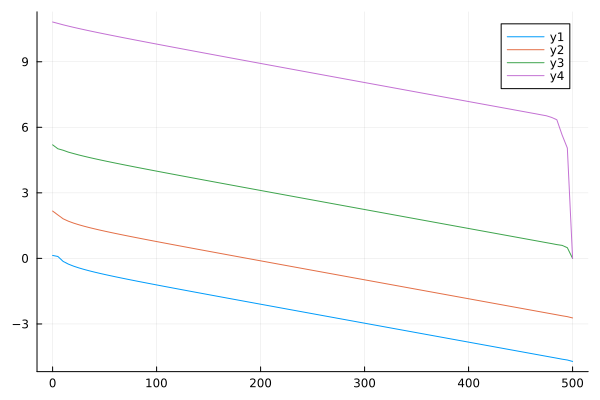

In [5]:
yvals = collect(1:4) .* div(p.Ny, 4)
plt = plot(m.agrid, m.policy.a[:, yvals] .- m.agrid)

In [6]:
p = BewleyParameters(Ny = 30, σϵ = 0.05)
m = setup(p)
@time solve!(p, m);

 26.858347 seconds (1.03 G allocations: 25.506 GiB, 4.18% gc time, 0.01% compilation time)


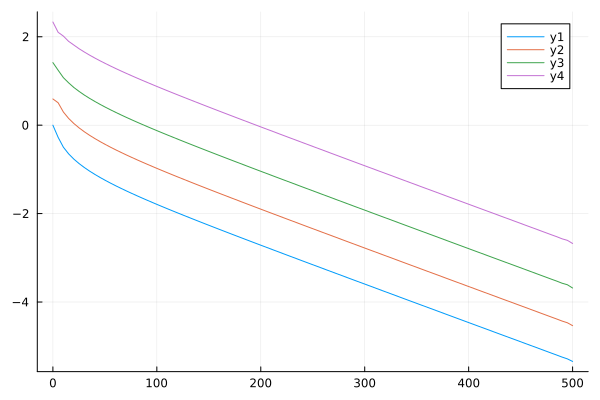

In [7]:
yvals = collect(1:4) .* div(p.Ny, 4)
plt = plot(m.agrid, m.policy.a[:, yvals] .- m.agrid)

As the variance of income shocks increases, the savings behavior of agents undergoes notable shifts. Firstly, heightened income volatility introduces greater uncertainty regarding future income levels. Consequently, agents often respond by increasing their precautionary savings. This adjustment allows them to buffer against potential income fluctuations and maintain a smoother consumption profile over time.

Moreover, in the face of increased income uncertainty, agents tend to exercise greater caution in their consumption choices. They may opt to reduce current consumption levels and allocate a larger portion of their income towards savings. This conservative approach helps them to better manage their financial resources and maintain stability amidst income variability.

Furthermore, the perception of heightened risk associated with income volatility can influence savings behavior. Risk-averse individuals, in particular, may respond by increasing their savings to hedge against adverse income shocks. This risk aversion leads to a greater inclination towards saving rather than spending, even when the average income remains constant.

The impact of increased income variability extends beyond individual consumption and savings decisions to affect investment strategies as well. Agents may become more hesitant to invest in long-term or risky assets, opting instead for safer, lower-yield investments or holding more liquid assets. This shift reflects a desire to prioritize financial stability and mitigate the potential negative consequences of income fluctuations.

Additionally, agents may adopt income smoothing strategies to counteract the effects of income volatility. These strategies could involve diversifying income sources, such as pursuing multiple streams of income, or purchasing insurance products to stabilize overall income levels. Such measures contribute to shaping savings behavior towards a more conservative and risk-averse approach, emphasizing stability and security in financial decisions.

Part b

In [109]:
p = BewleyParameters(Ny = 30, σϵ = 0.16, δ = 0.05, φ = 0.5)
m = setup(p)
@time solve!(p, m);

 38.622688 seconds (1.00 G allocations: 25.014 GiB, 3.84% gc time, 0.61% compilation time: 100% of which was recompilation)


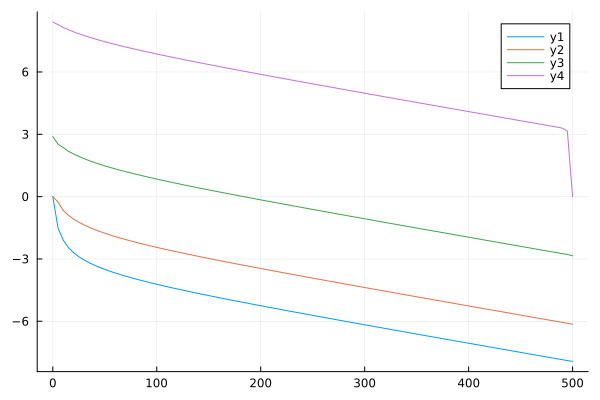

In [9]:
yvals = collect(1:4) .* div(p.Ny, 4)
plt = plot(m.agrid, m.policy.a[:, yvals] .- m.agrid)

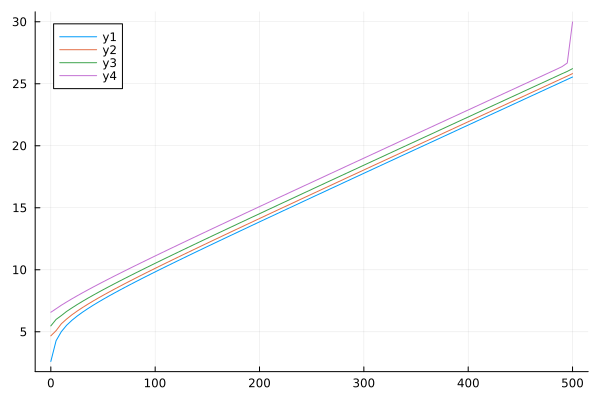

In [10]:
yvals = collect(1:4) .* div(p.Ny, 4)
plt = plot(m.agrid, m.policy.c[:, yvals])

Part c

In [15]:
function simulate(p::BewleyParameters, m; N = 10_000, T = 1000)
    @unpack agrid, ygrid, policy, P = m
    @unpack δ, φ = p
    # mc = rouwenhorst(p.Ny, p.ρ, p.σϵ)
    a  = ones(N) * mean(extrema(agrid))
    y  = ones(N) * ygrid[div(length(ygrid), 2)]
    Pc = cumsum(P, dims=1)
    
    # To produce them all at once
    # y = reshape(QuantEcon.simulate(m.mc, N * T), N, T)

    â = LinearInterpolation((agrid, ygrid), policy.a)
    ĉ = LinearInterpolation((agrid, ygrid), policy.c)

    for t in 1:T
        Threads.@threads for i in 1:N
            # Step assets forward 
            a′   = â(a[i], y[i])
            a[i] = a′
            
            # Step income forward (random draw from our process)
            z    = rand()
            yi   = searchsortedfirst(ygrid, (1-δ)y[i]+ δ*y[i]) 
            y[i] = ygrid[yi]
        end
    end

    return (; a, y, c = ĉ.(a, y))
end

            # Step income forward (random draw from our process)
            z    = rand()
            yi   = searchsortedfirst(ygrid, y[i]) 
            yi′  = @views searchsortedfirst(Pc[:, δ*yi], (1-δ)*y[i])  
            yi′_alt = @views searchsortedfirst(Pc[:, (1-δ)*yi], (δ*y[i])
            y[i] = ygrid[yi′]

LoadError: UndefVarError: `ygrid` not defined

In [24]:
function simulate(p::BewleyParameters, m; N = 10_000, T = 1000)
    @unpack agrid, ygrid, policy, P = m
    # mc = rouwenhorst(p.Ny, p.ρ, p.σϵ)
    a  = ones(N) * mean(extrema(agrid))
    y  = ones(N) * ygrid[div(length(ygrid), 2)]
    Pc = cumsum(P, dims=1)
    
    # To produce them all at once
    # y = reshape(QuantEcon.simulate(m.mc, N * T), N, T)

    â = LinearInterpolation((agrid, ygrid), policy.a)
    ĉ = LinearInterpolation((agrid, ygrid), policy.c)

    for t in 1:T
        Threads.@threads for i in 1:N
            # Step assets forward 
            a′   = â(a[i], y[i])
            a[i] = a′
            
            # Step income forward (random draw from our process)
            z    = rand()
            yi   = searchsortedfirst(ygrid, y[i]) 
            yi′  = @views searchsortedfirst(Pc[:, yi], z)  
            y[i] = ygrid[yi′]
        end
    end

    return (; a, y, c = ĉ.(a, y))
end

simulate (generic function with 1 method)

In [ ]:
function simulate(p::BewleyParams, m; N = 10_000, T = 1000)
    @unpack agrid, ygrid, policy, P = m
    # mc = rouwenhorst(p.Ny, p.ρ, p.σϵ)
    a  = ones(N) * mean(extrema(agrid))
    y  = ones(N) * ygrid[div(length(ygrid), 2)]
    
    # To produce them all at once
    # y = reshape(QuantEcon.simulate(m.mc, N * T), N, T)

    â = LinearInterpolation((agrid, ygrid), policy.a)
    ĉ = LinearInterpolation((agrid, ygrid), policy.c)


    for t in 1:T
        Threads.@threads for i in 1:N
            # Step assets forward 
            a′   = â(a[i], y[i])
            a[i] = a′
            
            # Step income forward (random draw from our process)
            z    = rand()
            yi   = searchsortedfirst(ygrid, y[i]) 
            yi′  = @views searchsortedfirst(Pc[:, yi], z)  
            y[i] = ygrid[yi′]
        end
    end

    return (; a, y, c = ĉ.(a, y))
end

In [129]:
using DataFrames, DataFramesMeta


@time df = simulate(p, m, T = 300) |> DataFrame
plt1 = histogram(df.a,
    xlabel = "Assets",
    ylabel = "Density",
    normed = true,
    title  = "Marginal Distribution of Assets",
    label  = ""
)

LoadError: TaskFailedException

[91m    nested task error: [39mBoundsError: attempt to access 30-element StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64} at index [31]
    Stacktrace:
     [1] [0m[1mthrow_boundserror[22m[0m[1m([22m[90mA[39m::[0mStepRangeLen[90m{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}[39m, [90mI[39m::[0mTuple[90m{Int64}[39m[0m[1m)[22m
    [90m   @[39m [90mBase[39m [90m./[39m[90m[4mabstractarray.jl:737[24m[39m
     [2] [0m[1mcheckbounds[22m
    [90m   @[39m [90m./[39m[90m[4mabstractarray.jl:702[24m[39m[90m [inlined][39m
     [3] [0m[1mgetindex[22m
    [90m   @[39m [90m./[39m[90m[4mrange.jl:955[24m[39m[90m [inlined][39m
     [4] [0m[1mmacro expansion[22m
    [90m   @[39m [90m./[39m[90m[4mIn[128]:29[24m[39m[90m [inlined][39m
     [5] [0m[1m(::var"#1311#threadsfor_fun#246"{var"#1311#threadsfor_fun#245#247"{Interpolations.Extrapolation{Float64, 2, ScaledInterpolation{Float64, 2, Interpolations.BSplineInterpolation{Float64, 2, Matrix{Float64}, BSpline{Linear{Throw{OnGrid}}}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Tuple{LinRange{Float64, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Throw{Nothing}}, LinearAlgebra.Adjoint{Float64, Matrix{Float64}}, Vector{Float64}, Vector{Float64}, Float64, Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [36mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:215[24m[39m
     [6] [0m[1m#1311#threadsfor_fun[22m
    [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:182[24m[39m[90m [inlined][39m
     [7] [0m[1m(::Base.Threads.var"#1#2"{var"#1311#threadsfor_fun#246"{var"#1311#threadsfor_fun#245#247"{Interpolations.Extrapolation{Float64, 2, ScaledInterpolation{Float64, 2, Interpolations.BSplineInterpolation{Float64, 2, Matrix{Float64}, BSpline{Linear{Throw{OnGrid}}}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Tuple{LinRange{Float64, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Throw{Nothing}}, LinearAlgebra.Adjoint{Float64, Matrix{Float64}}, Vector{Float64}, Vector{Float64}, Float64, Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:154[24m[39m

  0.242313 seconds (1.85 k allocations: 902.062 KiB)


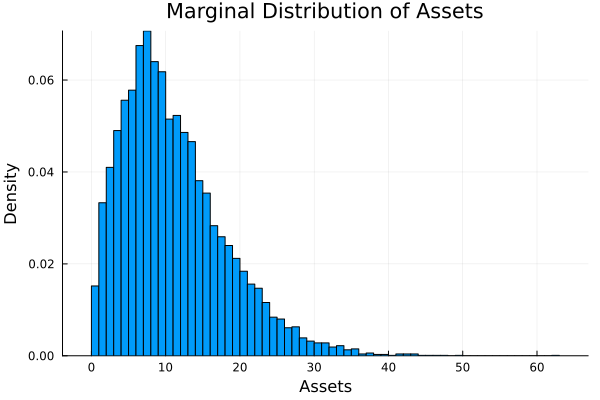

In [19]:
p = BewleyParameters(Ny = 30, σϵ = 0.16, δ = 0.1, φ = 0.5)

@time df = simulate(p, m, T = 300) |> DataFrame
plt1 = histogram(df.a,
    xlabel = "Assets",
    ylabel = "Density",
    normed = true,
    title  = "Marginal Distribution of Assets",
    label  = ""
)

[1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589267279, 1.625062589

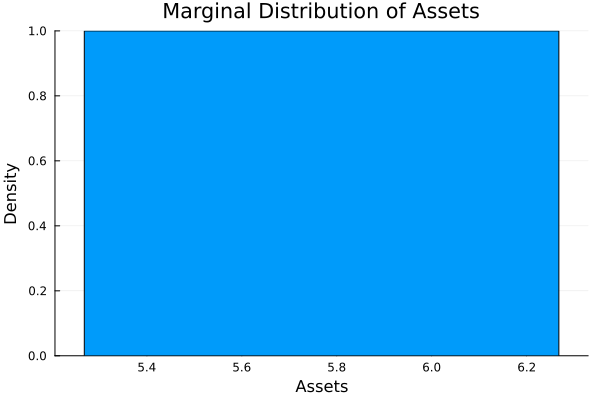

In [ ]:
function simulate(p::BewleyParameters, m; N = 10_000, T = 1000)
    @unpack agrid, ygrid, policy, V0, P = m
    @unpack δ, φ, interp_mode = p
    a  = ones(N) * mean(extrema(agrid))
    y  = ones(N) * ygrid[div(length(ygrid), 2)]
    Pc = cumsum(P, dims=1)
    
    â = LinearInterpolation((agrid, ygrid), policy.a)
    ĉ = LinearInterpolation((agrid, ygrid), policy.c)
    E = V0 * P
    EV̂ = LinearInterpolation((agrid, ygrid), E)
    
    for t in 1:T
        Threads.@threads for i in 1:N
            a′   = â(a[i], y[i])
            a[i] = a′


            obj = Int(ceil(φ*y[i]))
            if obj > length(ygrid)
                obj = length(ygrid)
            end
            yi = y[i]
            yi   = searchsortedfirst(ygrid, yi) 
            y[i] = ygrid[yi]
        end
    end

    return (; a, y, c = ĉ.(a, y))
end


p = BewleyParameters(Ny = 30, σϵ = 0.16, δ = 0.5, φ = 0.5)

@time df = simulate(p, m, T = 300) |> DataFrame
plt1 = histogram(df.a,
    xlabel = "Assets",
    ylabel = "Density",
    normed = true,
    title  = "Marginal Distribution of Assets",
    label  = ""
)

In [133]:
function simulate(p::BewleyParameters, m; N = 10_000, T = 1000)
    @unpack agrid, ygrid, policy, V0, P, EV = m
    @unpack δ, φ, interp_mode = p
    a  = ones(N) * mean(extrema(agrid))
    y  = ones(N) * ygrid[div(length(ygrid), 2)]
    Pc = cumsum(P, dims=1)
    
    â = LinearInterpolation((agrid, ygrid), policy.a)
    ĉ = LinearInterpolation((agrid, ygrid), policy.c,)
    EV̂ = interpolant(interp_mode, (agrid, ygrid), EV)

    for t in 1:T
        Threads.@threads for i in 1:N
            a′   = â(a[i], y[i])
            a[i] = a′

            # Simulate income shocks
            obj = Int(ceil(φ * y[i]))
            obj > length(ygrid) && (obj = length(ygrid))
            yi = searchsortedfirst(ygrid, y[i]) 
            yi > length(ygrid) && (yi = length(ygrid))
            yik = (1-δ)*y[i] + δ*φ * y[i]
            yip = @views searchsortedfirst(Pc[:, yi], yik)
            y[i] = ygrid[yip]
        end
    end

    return DataFrame(a = a, y = y, c = ĉ.(a, y))
end


p = BewleyParameters(Ny = 30, σϵ = 0.16, δ = 0.2, φ = 0.5)
df = simulate(p, m, T = 300)

plt1 = histogram(df.a,
    xlabel = "Assets",
    ylabel = "Density",
    normed = true,
    title  = "Marginal Distribution of Assets",
    label  = "",
    legend = :topright
)

display(plt1)

LoadError: TaskFailedException

[91m    nested task error: [39mBoundsError: attempt to access 30-element StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64} at index [31]
    Stacktrace:
     [1] [0m[1mthrow_boundserror[22m[0m[1m([22m[90mA[39m::[0mStepRangeLen[90m{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}[39m, [90mI[39m::[0mTuple[90m{Int64}[39m[0m[1m)[22m
    [90m   @[39m [90mBase[39m [90m./[39m[90m[4mabstractarray.jl:737[24m[39m
     [2] [0m[1mcheckbounds[22m
    [90m   @[39m [90m./[39m[90m[4mabstractarray.jl:702[24m[39m[90m [inlined][39m
     [3] [0m[1mgetindex[22m
    [90m   @[39m [90m./[39m[90m[4mrange.jl:955[24m[39m[90m [inlined][39m
     [4] [0m[1mmacro expansion[22m
    [90m   @[39m [90m./[39m[90m[4mIn[133]:24[24m[39m[90m [inlined][39m
     [5] [0m[1m(::var"#1376#threadsfor_fun#260"{var"#1376#threadsfor_fun#259#261"{Interpolations.Extrapolation{Float64, 2, ScaledInterpolation{Float64, 2, Interpolations.BSplineInterpolation{Float64, 2, Matrix{Float64}, BSpline{Linear{Throw{OnGrid}}}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Tuple{LinRange{Float64, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Throw{Nothing}}, Matrix{Float64}, Vector{Float64}, Vector{Float64}, Float64, Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [36mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:215[24m[39m
     [6] [0m[1m#1376#threadsfor_fun[22m
    [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:182[24m[39m[90m [inlined][39m
     [7] [0m[1m(::Base.Threads.var"#1#2"{var"#1376#threadsfor_fun#260"{var"#1376#threadsfor_fun#259#261"{Interpolations.Extrapolation{Float64, 2, ScaledInterpolation{Float64, 2, Interpolations.BSplineInterpolation{Float64, 2, Matrix{Float64}, BSpline{Linear{Throw{OnGrid}}}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Tuple{LinRange{Float64, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Throw{Nothing}}, Matrix{Float64}, Vector{Float64}, Vector{Float64}, Float64, Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:154[24m[39m

In [134]:
using DataFrames, Plots

function simulate(p::BewleyParameters, m; N = 10_000, T = 1000)
    @unpack agrid, ygrid, policy, V0, P, EV = m
    @unpack δ, φ, interp_mode = p
    a  = ones(N) * mean(extrema(agrid))
    y  = ones(N) * ygrid[div(length(ygrid), 2)]
    Pc = cumsum(P, dims=1)
    
    â = LinearInterpolation((agrid, ygrid), policy.a)
    ĉ = LinearInterpolation((agrid, ygrid), policy.c)
    EV̂ = interpolant(interp_mode, (agrid, ygrid), EV)

    for t in 1:T
        Threads.@threads for i in 1:N
            a′   = â(a[i], y[i])
            a[i] = a′

            # Simulate income shocks
            obj = Int(ceil(φ * y[i]))
            obj > length(ygrid) && (obj = length(ygrid))
            yi = searchsortedfirst(ygrid, y[i]) 
            yi > length(ygrid) && (yi = length(ygrid))
            yik = (1-δ)*y[i] + δ*φ * y[i]
            yip = @views searchsortedfirst(Pc[:, yi], yik)
            y[i] = ygrid[yip]
        end
    end

    return DataFrame(a = a, y = y, c = ĉ.(a, y))
end

# Define parameters
p = BewleyParameters(Ny = 30, σϵ = 0.16, δ = 0.2, φ = 0.5)

# Simulate data
df = simulate(p, m, T = 300)

# Plot histogram of asset distribution
plt1 = histogram(df.a,
    xlabel = "Assets",
    ylabel = "Density",
    normed = true,
    title  = "Marginal Distribution of Assets",
    label  = "",
    legend = :topright
)

display(plt1)


LoadError: TaskFailedException

[91m    nested task error: [39mBoundsError: attempt to access 30-element StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64} at index [31]
    Stacktrace:
     [1] [0m[1mthrow_boundserror[22m[0m[1m([22m[90mA[39m::[0mStepRangeLen[90m{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}[39m, [90mI[39m::[0mTuple[90m{Int64}[39m[0m[1m)[22m
    [90m   @[39m [90mBase[39m [90m./[39m[90m[4mabstractarray.jl:737[24m[39m
     [2] [0m[1mcheckbounds[22m
    [90m   @[39m [90m./[39m[90m[4mabstractarray.jl:702[24m[39m[90m [inlined][39m
     [3] [0m[1mgetindex[22m
    [90m   @[39m [90m./[39m[90m[4mrange.jl:955[24m[39m[90m [inlined][39m
     [4] [0m[1mmacro expansion[22m
    [90m   @[39m [90m./[39m[90m[4mIn[134]:26[24m[39m[90m [inlined][39m
     [5] [0m[1m(::var"#1391#threadsfor_fun#264"{var"#1391#threadsfor_fun#263#265"{Interpolations.Extrapolation{Float64, 2, ScaledInterpolation{Float64, 2, Interpolations.BSplineInterpolation{Float64, 2, Matrix{Float64}, BSpline{Linear{Throw{OnGrid}}}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Tuple{LinRange{Float64, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Throw{Nothing}}, Matrix{Float64}, Vector{Float64}, Vector{Float64}, Float64, Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [36mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:215[24m[39m
     [6] [0m[1m#1391#threadsfor_fun[22m
    [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:182[24m[39m[90m [inlined][39m
     [7] [0m[1m(::Base.Threads.var"#1#2"{var"#1391#threadsfor_fun#264"{var"#1391#threadsfor_fun#263#265"{Interpolations.Extrapolation{Float64, 2, ScaledInterpolation{Float64, 2, Interpolations.BSplineInterpolation{Float64, 2, Matrix{Float64}, BSpline{Linear{Throw{OnGrid}}}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Tuple{LinRange{Float64, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Throw{Nothing}}, Matrix{Float64}, Vector{Float64}, Vector{Float64}, Float64, Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:154[24m[39m

In [ ]:
using DataFrames, Plots

function simulate(p::BewleyParameters, m; N = 10_000, T = 1000)
    @unpack agrid, ygrid, policy, V0, P = m
    @unpack δ, φ, interp_mode = p
    â = interpolate((agrid, ygrid), policy.a, Gridded(Linear()))
    ĉ = interpolate((agrid, ygrid), policy.c, Gridded(Linear()))
    E = V0 * P
    EV̂ = interpolate((agrid, ygrid), E, Gridded(Linear()))
    
    a = ones(N) * mean(extrema(agrid))
    y = ones(N) * mean(extrema(ygrid))
    
    for t in 1:T
        Threads.@threads for i in 1:N
            # Update asset holdings based on policy function
            a[i] = â(clamp(a[i], minimum(agrid), maximum(agrid)), y[i])
            
            # Generate income shock
            obj = min(Int(ceil(φ * y[i])), length(ygrid))
            yi = searchsortedfirst(ygrid, y[i])
            y[i] = ygrid[min(yi, length(ygrid))]
            
            # Adjust income shock for disaster scenario
            if rand() < δ
                y[i] *= φ
            end
        end
    end

    return DataFrame(a = a, y = y, c = ĉ.(clamp.(a, minimum(agrid), maximum(agrid)), y))
end

p = BewleyParameters(Ny = 30, σϵ = 0.16, δ = 0.5, φ = 0.5)
df = simulate(p, m, N = 10000, T = 300)

plt1 = histogram(df.a,
    xlabel = "Assets",
    ylabel = "Density",
    normed = true,
    title  = "Marginal Distribution of Assets",
    label  = "",
    legend = :topright
)

display(plt1)


LoadError: TaskFailedException

[91m    nested task error: [39mBoundsError: attempt to access 100×30 interpolate((LinRange{Float64}(0.0, 500.0, 100),0.46014842208442897:0.083208154798775:2.873184911248904), ::Matrix{Float64}, Gridded(Linear())) with element type Float64 at index [240.7249562540179, 0.438094598039152]
    Stacktrace:
     [1] [0m[1mthrow_boundserror[22m[0m[1m([22m[90mA[39m::[0mInterpolations.GriddedInterpolation[90m{Float64, 2, Matrix{Float64}, Gridded{Linear{Throw{OnGrid}}}, Tuple{LinRange{Float64, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}[39m, [90mI[39m::[0mTuple[90m{Float64, Float64}[39m[0m[1m)[22m
    [90m   @[39m [90mBase[39m [90m./[39m[90m[4mabstractarray.jl:737[24m[39m
     [2] [0m[1mGriddedInterpolation[22m
    [90m   @[39m [90m~/.julia/packages/Interpolations/91PhN/src/gridded/[39m[90m[4mindexing.jl:3[24m[39m[90m [inlined][39m
     [3] [0m[1mmacro expansion[22m
    [90m   @[39m [90m./[39m[90m[4mIn[172]:17[24m[39m[90m [inlined][39m
     [4] [0m[1m(::var"#2621#threadsfor_fun#400"{var"#2621#threadsfor_fun#399#401"{Vector{Float64}, Vector{Float64}, Interpolations.GriddedInterpolation{Float64, 2, Matrix{Float64}, Gridded{Linear{Throw{OnGrid}}}, Tuple{LinRange{Float64, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}, Float64, Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, LinRange{Float64, Int64}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:215[24m[39m
     [5] [0m[1m#2621#threadsfor_fun[22m
    [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:182[24m[39m[90m [inlined][39m
     [6] [0m[1m(::Base.Threads.var"#1#2"{var"#2621#threadsfor_fun#400"{var"#2621#threadsfor_fun#399#401"{Vector{Float64}, Vector{Float64}, Interpolations.GriddedInterpolation{Float64, 2, Matrix{Float64}, Gridded{Linear{Throw{OnGrid}}}, Tuple{LinRange{Float64, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}, Float64, Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, LinRange{Float64, Int64}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:154[24m[39m

In [ ]:
using DataFrames, Plots

function simulate(p::BewleyParameters, m; N = 10_000, T = 1000)
    @unpack agrid, ygrid, policy, P = m
    @unpack δ, φ, interp_mode = p

    a  = ones(N) * mean(extrema(agrid))
    y  = ones(N) * ygrid[div(length(ygrid), 2)]
    Pc = cumsum(P, dims=1)

    â = LinearInterpolation((agrid, ygrid), policy.a)
    ĉ = LinearInterpolation((agrid, ygrid), policy.c)
   

    
    for t in 1:T
        Threads.@threads for i in 1:N
            # Update asset holdings based on policy function
            a[i] = â(a[i], y[i])
            
            # Generate income shock
            
            yi = searchsortedfirst(ygrid, y[i])
            y[i] = ygrid[yi]
            
            # Adjust income shock for disaster scenario
            if rand() < δ
                y[i] *= φ
            end
        end
    end

    return (;a = a, y = y, c = ĉ.(a, y))
end


p = BewleyParameters(Ny = 30, σϵ = 0.16, δ = 0.5, φ = 0.5) 
df = simulate(p, m, N = 10000, T = 300) |> DataFrame

plt1 = histogram(df.a,
    xlabel = "Assets",
    ylabel = "Density",
    normed = true,
    title  = "Marginal Distribution of Assets",
    label  = "",
    legend = :topright
)

display(plt1)



LoadError: TaskFailedException

[91m    nested task error: [39mBoundsError: attempt to access 100×30 extrapolate(scale(interpolate(::Matrix{Float64}, BSpline(Linear())), (LinRange{Float64}(0.0, 500.0, 100), 0.46014842208442897:0.083208154798775:2.873184911248904)), Throw()) with element type Float64 at index [240.44980039124627, 0.438094598039152]
    Stacktrace:
     [1] [0m[1mthrow_boundserror[22m[0m[1m([22m[90mA[39m::[0mInterpolations.Extrapolation[90m{Float64, 2, ScaledInterpolation{Float64, 2, Interpolations.BSplineInterpolation{Float64, 2, Matrix{Float64}, BSpline{Linear{Throw{OnGrid}}}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Tuple{LinRange{Float64, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Throw{Nothing}}[39m, [90mI[39m::[0mTuple[90m{Float64, Float64}[39m[0m[1m)[22m
    [90m   @[39m [90mBase[39m [90m./[39m[90m[4mabstractarray.jl:737[24m[39m
     [2] [0m[1minbounds_index[22m
    [90m   @[39m [90m~/.julia/packages/Interpolations/91PhN/src/extrapolation/[39m[90m[4mextrapolation.jl:111[24m[39m[90m [inlined][39m
     [3] [0m[1minbounds_position[22m
    [90m   @[39m [90m~/.julia/packages/Interpolations/91PhN/src/extrapolation/[39m[90m[4mextrapolation.jl:102[24m[39m[90m [inlined][39m
     [4] [0m[1minbounds_position[22m
    [90m   @[39m [90m~/.julia/packages/Interpolations/91PhN/src/extrapolation/[39m[90m[4mextrapolation.jl:103[24m[39m[90m [inlined][39m
     [5] [0m[1mExtrapolation[22m
    [90m   @[39m [90m~/.julia/packages/Interpolations/91PhN/src/extrapolation/[39m[90m[4mextrapolation.jl:48[24m[39m[90m [inlined][39m
     [6] [0m[1mmacro expansion[22m
    [90m   @[39m [90m./[39m[90m[4mIn[186]:19[24m[39m[90m [inlined][39m
     [7] [0m[1m(::var"#2945#threadsfor_fun#448"{var"#2945#threadsfor_fun#447#449"{Interpolations.Extrapolation{Float64, 2, ScaledInterpolation{Float64, 2, Interpolations.BSplineInterpolation{Float64, 2, Matrix{Float64}, BSpline{Linear{Throw{OnGrid}}}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Tuple{LinRange{Float64, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Throw{Nothing}}, Vector{Float64}, Vector{Float64}, Float64, Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m   @[39m [35mMain[39m [90m./[39m[90m[4mthreadingconstructs.jl:215[24m[39m
     [8] [0m[1m#2945#threadsfor_fun[22m
    [90m   @[39m [90m./[39m[90m[4mthreadingconstructs.jl:182[24m[39m[90m [inlined][39m
     [9] [0m[1m(::Base.Threads.var"#1#2"{var"#2945#threadsfor_fun#448"{var"#2945#threadsfor_fun#447#449"{Interpolations.Extrapolation{Float64, 2, ScaledInterpolation{Float64, 2, Interpolations.BSplineInterpolation{Float64, 2, Matrix{Float64}, BSpline{Linear{Throw{OnGrid}}}, Tuple{Base.OneTo{Int64}, Base.OneTo{Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Tuple{LinRange{Float64, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}, BSpline{Linear{Throw{OnGrid}}}, Throw{Nothing}}, Vector{Float64}, Vector{Float64}, Float64, Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m   @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:154[24m[39m

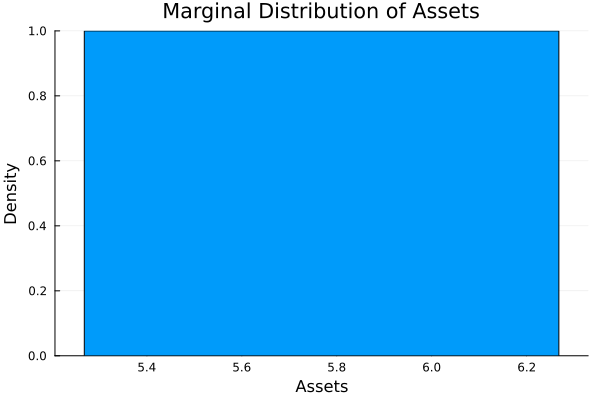

In [ ]:
using DataFrames, Plots

function simulate(p::BewleyParameters, m; N = 10_000, T = 1000)
    @unpack agrid, ygrid, policy, P = m
    @unpack δ, φ, interp_mode = p

    â = LinearInterpolation((agrid, ygrid), policy.a, extrapolation_bc = Line())
    ĉ = LinearInterpolation((agrid, ygrid), policy.c, extrapolation_bc = Line())

    a = ones(N) * mean(extrema(agrid))
    y = ones(N) * ygrid[div(length(ygrid), 2)]
    
    for t in 1:T
        Threads.@threads for i in 1:N
            # Update asset holdings based on policy function
            a[i] = â(a[i], y[i])

            # Generate income shock
            yi = searchsortedfirst(ygrid, y[i])
            y[i] = ygrid[min(yi, length(ygrid))]

            # Adjust income shock for disaster scenario
            if rand() < δ
                y[i] *= φ
            end
        end
    end

    return DataFrame(a = a, y = y, c = ĉ.(a, y))
end

p = BewleyParameters(Ny = 30, σϵ = 0.16, δ = 0.0, φ = 0.5) 
df = simulate(p, m, N = 10000, T = 300) |> DataFrame

plt1 = histogram(df.a,
    xlabel = "Assets",
    ylabel = "Density",
    normed = true,
    title  = "Marginal Distribution of Assets",
    label  = "",
    legend = :topright
)

display(plt1)
